Compute correction for dust extinction due to the extinction within the galaxy (should be a function of inclination).

In [81]:
import numpy as np

from astropy.table import Table, join
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import astropy.constants as const
import astropy.units as u

from hyperfit.linfit import LinFit

import time

import corner

import pickle

import matplotlib.pyplot as plt
#UNCOMMENT FOR 3D PLOTS
# %matplotlib widget

import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [82]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Galaxies

In [83]:
# gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/'
gals_directory = ''
gals_filename = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot_VI.fits'

gals = Table.read(gals_directory + gals_filename)

In [84]:
# # ###### add the PHOTOSYS row to the table
# tjura = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/desi_pv_jura_healpix.fits')

# gals['PHOTSYS'] =np.nan
# gals['PHOTSYS'] = gals['PHOTSYS'].astype(np.bytes_)

# i=0
# while i < len(gals):
#     value = tjura[gals['SGA_ID'][i] == tjura['SGA_ID']] 
#     gals['PHOTSYS'][i] = value['PHOTSYS'][0]
#     i+=1

# # # gals.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot_VI.fits', overwrite=True)

In [85]:
gals[:5]

<Table length=5>
SGA_ID  SGA_GALAXY ...      R26_kpc            R26_kpc_err     
                   ...        kpc                  kpc         
int64    bytes16   ...      float64              float64       
------ ----------- ... ------------------ ---------------------
    20 SGA-2020 20 ... 25.526842684933225 0.0019003803738090622
    32 SGA-2020 32 ... 45.361963270903466  0.016110728584642294
    38 SGA-2020 38 ... 23.108068231780635 0.0011214619105580901
    53 SGA-2020 53 ... 26.202174084154187  0.004942635594012967
    55 SGA-2020 55 ... 14.522328312540912  0.003779849352107925

# Empirical internal dust extinction correction

Can we find (and correct for) any correlation between the axis ratio and the color of the galaxies?

## Calculate the "known" photometric corrections

### Survey offsets

In [86]:
sys_corr, sys_corr_err = BASS_corr(gals['PHOTSYS'])

### Dust corrections

In [87]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [88]:
dust_corr, dust_corr_err = MW_dust(gals['RA'], gals['DEC'], ebv_map)

/global/homes/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [89]:
# Flip NaN values to 0
dust_corr_err[np.isnan(dust_corr_err)] = 0

### $K$-corrections

In [90]:
zg0 = gals['Z_DESI'] >= 0

In [91]:
kcorr_zg0 = k_corr(gals['Z_DESI'][zg0], 
                   [gals['G_MAG_SB26'][zg0], gals['R_MAG_SB26'][zg0], gals['Z_MAG_SB26'][zg0]], 
                   [gals['G_MAG_SB26_ERR'][zg0], gals['R_MAG_SB26_ERR'][zg0], gals['Z_MAG_SB26_ERR'][zg0]])

In [92]:
kcorr = np.zeros((len(gals), 3))
kcorr[zg0] = kcorr_zg0

## Apply "known" corrections

In [93]:
gals['G_MAG_SB26_CORR'] = gals['G_MAG_SB26'] - dust_corr[0] + sys_corr + kcorr[:,0]
gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26'] - dust_corr[1] + sys_corr + kcorr[:,1]
gals['Z_MAG_SB26_CORR'] = gals['Z_MAG_SB26'] - dust_corr[2] + sys_corr + kcorr[:,2]

In [94]:
gals['G_MAG_SB26_ERR_CORR'] = np.sqrt(gals['G_MAG_SB26_ERR']**2 + dust_corr_err[0]**2 + sys_corr_err**2)
gals['R_MAG_SB26_ERR_CORR'] = np.sqrt(gals['R_MAG_SB26_ERR']**2 + dust_corr_err[1]**2 + sys_corr_err**2)
gals['Z_MAG_SB26_ERR_CORR'] = np.sqrt(gals['Z_MAG_SB26_ERR']**2 + dust_corr_err[2]**2 + sys_corr_err**2)

In [95]:
gals['R_MAG_SB26_ERR']

<Column name='R_MAG_SB26_ERR' dtype='float32' length=35682>
 0.010862263
 0.022476751
 0.031088097
 0.008801767
 0.015961537
  0.03637159
   0.0292718
 0.028633099
 0.033806317
 0.016245957
 0.011174367
 0.015874939
         ...
0.0071497266
 0.009778397
0.0126029905
 0.026224555
 0.026303183
 0.021352056
0.0061218785
  0.04196402
 0.014138819
 0.011967833
 0.028150462
 0.011406247

## Convert $R_{26}$ to kpc

In [96]:
dist = Distance(z=np.abs(gals['Z_DESI']), cosmology=Planck18)

In [97]:
rng = np.random.default_rng()

N_samples = 1000

dist_err = np.empty(len(dist))*u.Mpc

for i in range(len(dist_err)):
    
    z_desi_random = rng.normal(np.abs(gals['Z_DESI'][i]), 
                               np.abs(gals['ZERR_DESI'][i]), 
                               N_samples)
    
    d_random = Distance(z=z_desi_random, cosmology=Planck18, allow_negative=True)
    
    dist_err[i] = np.std(d_random)

In [98]:
gals['R26_kpc'] = dist.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)
gals['R26_kpc_err'] = dist_err.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)

## Compute Absolute Magnitudes

In [99]:
mu = Planck18.distmod(np.abs(gals['Z_DESI']))

gals['R_ABSMAG_SB26_CORR'] = gals['R_MAG_SB26_CORR'] - mu.value

## Correlation between color and axis ratio?

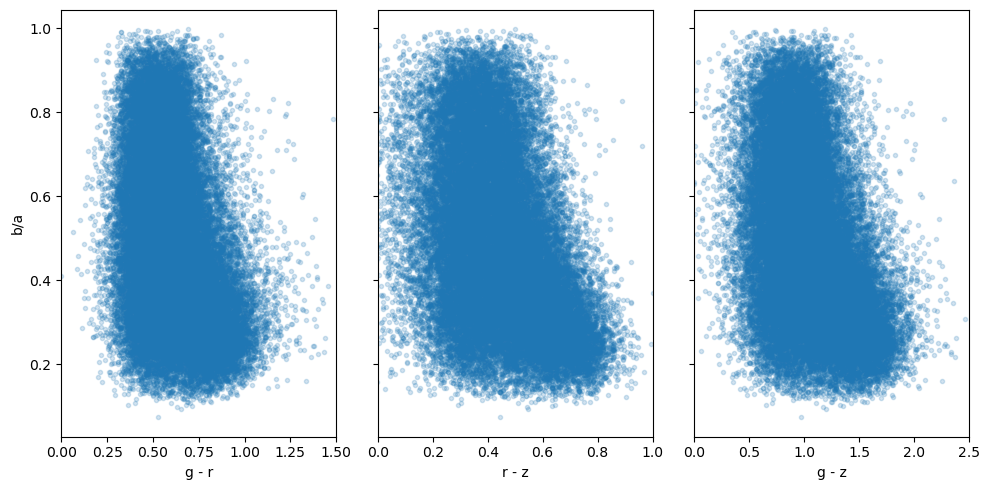

In [19]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([0, 1.5])

ax[1].plot(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r - z')
ax[1].set_xlim([0, 1])

ax[2].plot(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('g - z')
ax[2].set_xlim([0, 2.5]);

## Correlation between magnitude and axis ratio?

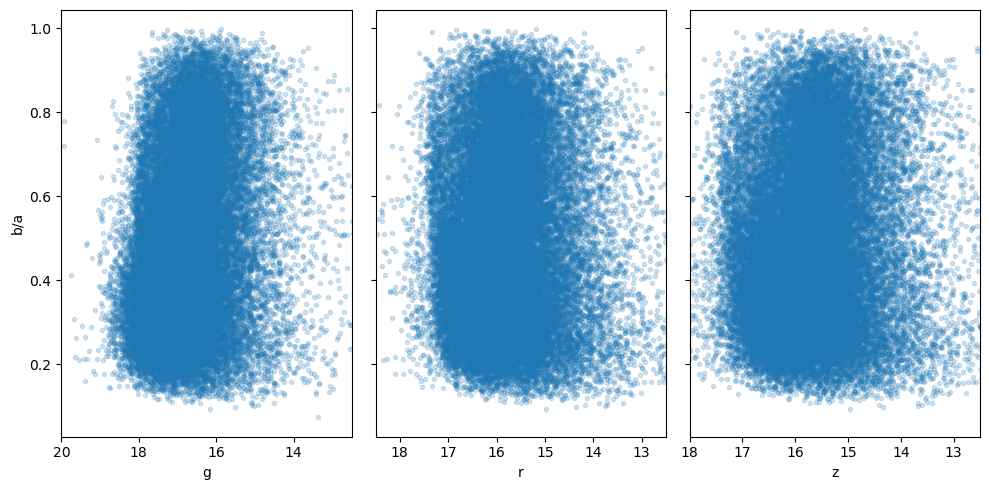

In [44]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

## Correlation between magnitude, $R_{26}$, and axis ratio?

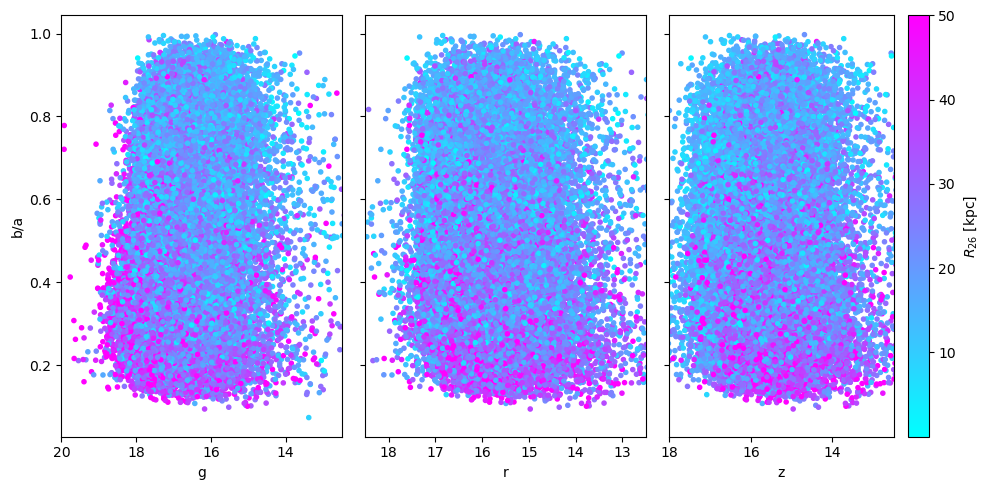

In [45]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].scatter(gals['G_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([20, 12.5])

ax[1].scatter(gals['R_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

zplot = ax[2].scatter(gals['Z_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5])

plt.colorbar(zplot, label='$R_{26}$ [kpc]');

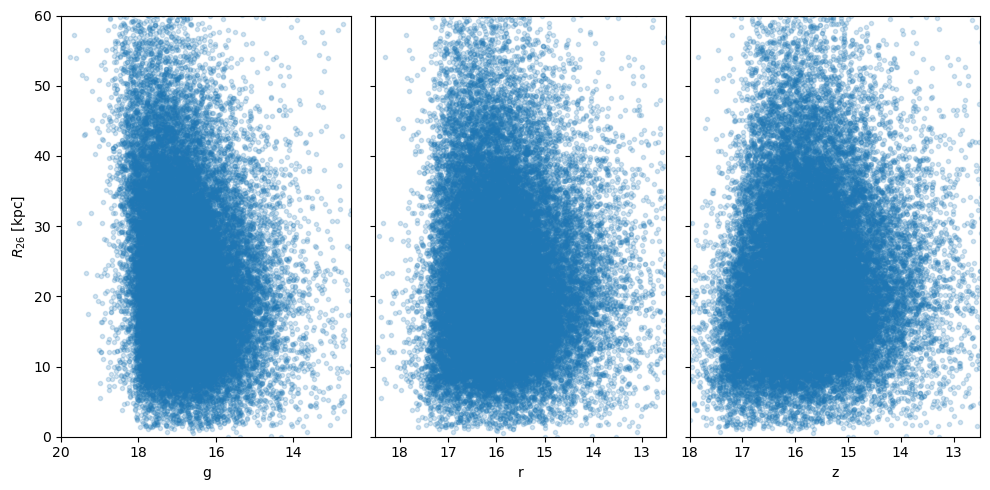

In [46]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('$R_{26}$ [kpc]')
ax[0].set_xlim([20, 12.5])
ax[0].set_ylim([0, 60])

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[1].set_xlabel('r')
ax[1].set_xlim([18.5, 12.5])

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[2].set_xlabel('z')
ax[2].set_xlim([18, 12.5]);

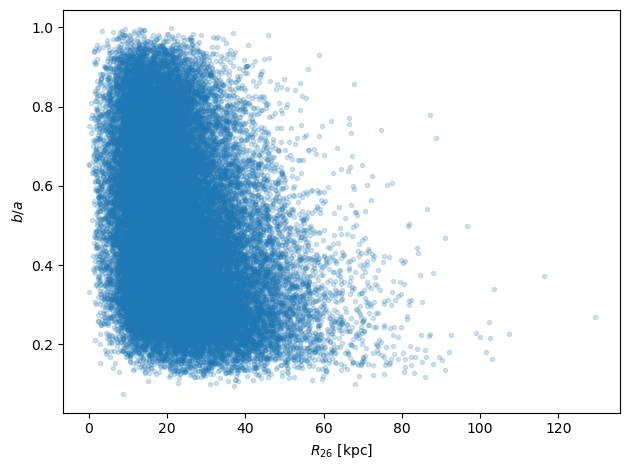

In [23]:
plt.figure(tight_layout=True)

plt.plot(gals['R26_kpc'], gals['BA'], '.', alpha=0.2)

plt.xlabel('$R_{26}$ [kpc]')
plt.ylabel('$b/a$');

In [1]:
# x = gals[gals['R26_kpc'] > 500]
# x


## Let's try fitting a plane to ($m_r$, $b/a$, $R_{26}$)

We're going to let $x = b/a$, $y = R_{26}$, and $z = m_r$

### Calculate median $m_r$ in bins of ($b/a$, $R_{26}$)

In [28]:
ba = np.arange(0,1,0.1)
R26 = np.arange(0,80,5)
ba_grid, R26_grid = np.meshgrid(ba, R26)

mr_grid = np.nan*np.ones(ba_grid.shape)

for i in range(ba_grid.shape[1]):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    for j in range(ba_grid.shape[0]):
        
        gals_R26_subset = gals_subset_ba[(gals_subset_ba['R26_kpc'] > j*5) & (gals_subset_ba['R26_kpc'] <= (j+1)*5)]
        
        mr_grid[j,i] = np.median(gals_R26_subset['R_MAG_SB26_CORR'])

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Do something to compute uncertainties in each of these bins

In [29]:
N = len(gals['R_MAG_SB26_CORR'])
N_grid = mr_grid.shape[0]*mr_grid.shape[1]

In [30]:
# Create covariance matrix, assuming each parameter is independent of the others
cov = np.empty((3, 3, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.001**2, 0., 0.], [0., gals['R26_kpc_err'][i]**2, 0.], [0., 0., gals['R_MAG_SB26_ERR_CORR'][i]**2]])
    

cov_grid = np.empty((3, 3, N_grid))

for i in range(N_grid):
    cov[:,:,i] = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [31]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.18979474466294


In [32]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_grid = LinFit([np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid) - mr_median], cov_grid)

In [33]:
# Set bounds of coefficients
bounds = ((-100.0, 0.0), (-10.0, 10.0), (-100.0, 100.0), (1.0e-5, 50.))

In [34]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_grid.emcee(bounds, verbose=True)

/global/homes/s/sgmoore1/.local/lib/python3.10/site-packages/hyperfit/linfit.py:207: RuntimeWarning: invalid value encountered in log
  lnlike = -0.5 * (np.log(orthvariance) + (originoffset ** 2) / orthvariance)


     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60165
     nit: 1000
 success: False
       x: array([-36.09939656,  25.96861369, -86.79411179,  42.7922018 ])


ValueError: Probability function returned NaN

In [ ]:
# Calculate parameter values and covariance matrix
A_ba, B_R26, C, sig = np.median(mcmc_samples, axis=1)

cov_fit = np.cov(mcmc_samples)

In [ ]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-60, 0], [-0.3, -0.1], [0, 40], [1, 15]],
                    labels=['$a_{b/a}$', '$b_{R_{26}}$', '$c$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

In [ ]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

# ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

# ax.plot_wireframe(ba_grid, R26_grid, A_ba*ba_grid + B_R26*R26_grid + (C + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

In [ ]:
# Results from minimize: [0.59896149, 0.00317231, 0.01740659, 0.18515053]
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)

ax.plot_wireframe(ba_grid, R26_grid, 0.59896149*ba_grid + 0.00317231*R26_grid + (0.01740659 + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

In [ ]:
plt.figure(tight_layout=True)

plt.plot(0.59896149*gals['BA'] + 0.00317231*gals['R26_kpc'] + (0.01740659 + mr_median), 
         gals['R_MAG_SB26_CORR'], 
         '.', 
         alpha=0.2)

plt.plot([12, 18], [12, 18], 'k')

plt.xlim([17, 16.3])
plt.ylim([19, 12])

plt.xlabel('$a(b/a) + bR_{26} + c$')
plt.ylabel('$m_r$');

## Let's try fitting a line to ($m_r$, $b/a$)

We're going to let $x = b/a$ and $y = m_r$

In [100]:
ba_binwidth=0.1
ba = np.arange(0.1,1,ba_binwidth)

In [101]:
N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [102]:
mr_bins = np.nan*np.ones(len(ba))
Mr_bins = np.nan*np.ones(len(ba))
cov_bins = np.nan*np.ones((2, 2, N_bins))


for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i] + ba_binwidth)]
    if len(gals_subset_ba) > 0:
        mr_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'])
        Mr_bins[i] = np.median(gals_subset_ba['R_ABSMAG_SB26_CORR'])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.std(gals_subset_ba['R_MAG_SB26_CORR'])**2]])
        # cov_bins[:,:,i] = np.array([[0., 0.], [0., np.mean((gals_subset_ba['R_MAG_SB26_CORR'] - mr_bins[i])**2)/len(gals_subset_ba)]])
        cov_bins[:,:,i] = np.array([[0., 0.], [0., 1/len(gals_subset_ba)]])

In [103]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
Mr_median = np.median(gals['R_ABSMAG_SB26_CORR'])
print(mr_median, Mr_median)

16.18979474466294 -20.743921373261458


In [104]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_bins = LinFit([ba, mr_bins - mr_median], cov_bins)
hf_bins_absmag = LinFit([ba, Mr_bins - Mr_median], cov_bins)

In [105]:
# Set bounds of coefficients
bounds = ((-100.0, 1.0), (-1.0, 10.0), (1.0e-5, 50.))
bounds_absmag = ((-100.0, 1.0), (-30.0, 10.0), (1.0e-5, 50.))

In [106]:
# Run MCMC to fit line
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_bins.emcee(bounds, verbose=True)
# mcmc_samples_absmag, mcmc_lnlike_absmag = hf_bins_absmag.emcee(bounds_absmag, verbose=True)

     fun: -16.790020136015553
     jac: array([0.00131806, 0.00092903, 0.00021814])
 message: 'Optimization terminated successfully.'
    nfev: 2626
     nit: 57
 success: True
       x: array([0.13909894, 0.18928211, 0.09199265])


100%|██████████| 1000/1000 [00:00<00:00, 2057.24it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.79363957 33.70455994 37.75817425] / 1939.6819783897051


100%|██████████| 1000/1000 [00:00<00:00, 2046.46it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.76865691 44.15004476 35.91076788] / 2207.5022380588375


100%|██████████| 1000/1000 [00:00<00:00, 2067.44it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.15731279 35.7950551  43.28060956] / 2307.865639365714


100%|██████████| 1000/1000 [00:00<00:00, 2044.07it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.08154059 42.34827813 49.14605248] / 2457.302624144193


100%|██████████| 1000/1000 [00:00<00:00, 2041.86it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.29822542 43.9935829  61.48034861] / 3074.0174305224164


100%|██████████| 1000/1000 [00:00<00:00, 2016.24it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.86995719 45.05595502 58.08236553] / 2904.1182763442935


100%|██████████| 1000/1000 [00:00<00:00, 2073.88it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.01369902 47.82090134 52.8947005 ] / 2644.735025006999


100%|██████████| 1000/1000 [00:00<00:00, 2045.09it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.96265672 51.99894286 49.27057804] / 2599.947142817576


100%|██████████| 1000/1000 [00:00<00:00, 2064.92it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.22084525 49.3960316  47.36643647] / 2469.801579801125


100%|██████████| 1000/1000 [00:00<00:00, 2067.19it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.14019402 52.28864316 47.37302621] / 2614.432157813194


100%|██████████| 1000/1000 [00:00<00:00, 2067.16it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.89993653 50.48318724 45.8506094 ] / 2524.1593619349287


In [108]:
# Calculate parameter values and covariance matrix
A_ba, B, sig = np.median(mcmc_samples, axis=1)
A_ba_absmag, B_absmag, sig_absmag = np.median(mcmc_samples_absmag, axis=1)
'''
cov_fit = np.cov(mcmc_samples)
A_ba_err = np.sqrt(cov_fit[0,0])
B_err = np.sqrt(cov_fit[1,1])
'''
A_ba_err = np.std(mcmc_samples[0][(-1.5 < mcmc_samples[0]) & (mcmc_samples[0] < 0)])
B_err = np.std(mcmc_samples[1][(0 < mcmc_samples[1]) & (mcmc_samples[1] < 1)])
A_ba_absmag_err = np.std(mcmc_samples_absmag[0][(-1.5 < mcmc_samples_absmag[0]) & (mcmc_samples_absmag[0] < 0)])
B_absmag_err = np.std(mcmc_samples_absmag[1][(0 < mcmc_samples_absmag[1]) & (mcmc_samples_absmag[1] < 1)])
'''
A_ba_err = np.quantile(mcmc_samples[0], [0.16, 0.5, 0.84])
B_err = np.quantile(mcmc_samples[1], [0.16, 0.5, 0.84])
'''
print(f'{A_ba:.2f} +/- {A_ba_err:.2f}')
print(f' {B:.2f} +/- {B_err:.2f}')
print(f'{A_ba_absmag:.2f} +/- {A_ba_absmag_err:.2f}')
print(f' {B_absmag:.2f} +/- {B_absmag_err:.2f}')

-0.79 +/- 0.22
 0.33 +/- 0.14
-0.18 +/- 0.14
 0.12 +/- 0.08


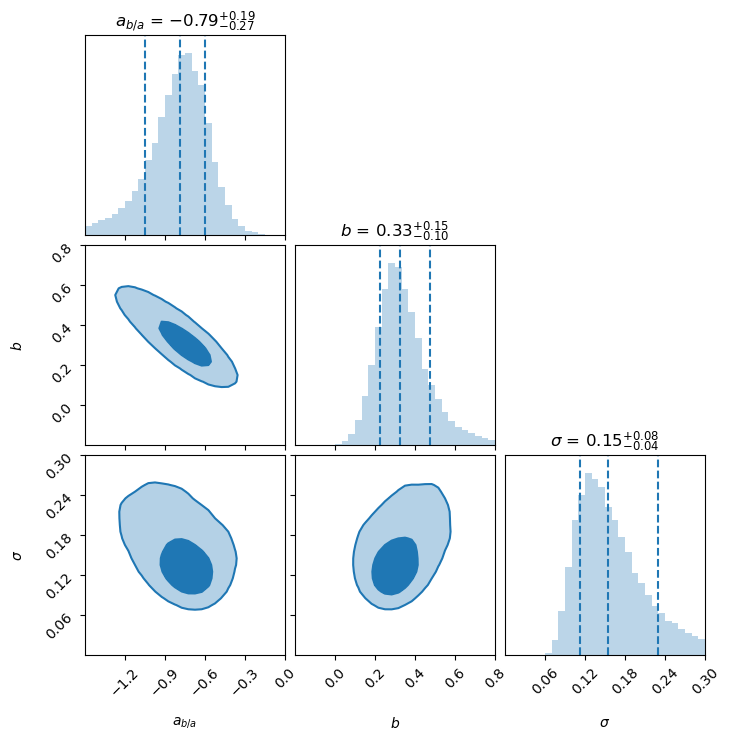

In [109]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.5, 0], [-0.2, 0.8], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [-3, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

# fig = corner.corner(mcmc_samples_absmag.T, 
#                     bins=30, 
#                     smooth=1, 
#                     range=[[-1.5, 0], [-0.2, 0.8], [0, 0.3]],
#                     # range=[[-6, 6], [-3, 3], [-3, 3]],
#                     labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
#                     levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
#                     quantiles=[0.16, 0.5, 0.84], 
#                     color='tab:blue', 
#                     hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
#                     plot_datapoints=False,
#                     fill_contours=True, 
#                     show_titles=True);

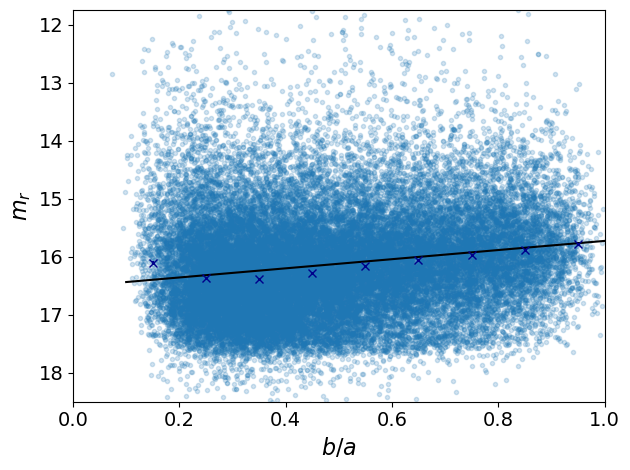

In [110]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

plt.plot([0.1, 1], A_ba*np.array([0.1, 1]) + (B + mr_median), 'k')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$', fontsize=16);

# plt.savefig('../Y3/Figures/jura_internalDustCorr_20241130.png', dpi=150);

### Save MCMC chains

In [111]:
temp_outfile = open('jura_internalDust_z0p1_mcmc.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median), temp_outfile)
temp_outfile.close()

## Apply the Correction

In [113]:
internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [A_ba, B], 
                                                         [A_ba_err, B_err])

r_mag_sb26_corr = gals['R_MAG_SB26_CORR'] - internalDust_corr
r_mag_sb26_corr_err = np.sqrt(gals['R_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)

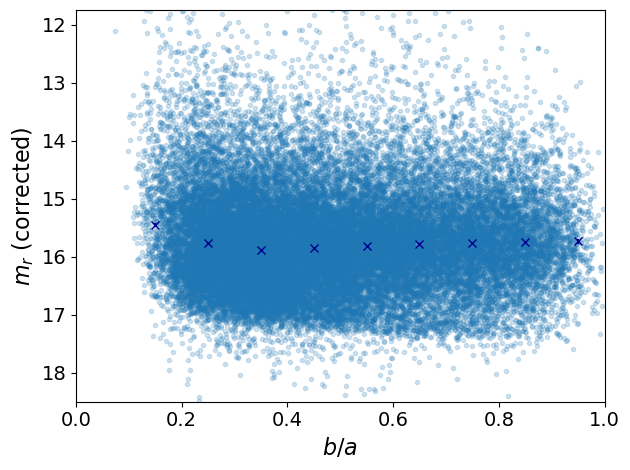

In [114]:
##### check if it removed the correlation:

mr_bins_updated = np.nan*np.ones(len(ba))
cov_bins_updated = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    ba_subset = (gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+0.1)
    if sum(ba_subset) > 0:
        mr_bins_updated[i] = np.median(r_mag_sb26_corr[ba_subset])
        cov_bins_updated[:,:,i] = np.array([[0., 0.], [0., 1/sum(ba_subset)]])


plt.figure(tight_layout=True)

plt.plot(gals['BA'], r_mag_sb26_corr, '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins_updated, yerr=np.sqrt(cov_bins_updated[1,1,:]), fmt='x', c='darkblue')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$ (corrected)', fontsize=16);

## Now repeat using the magnitudes in the g and z bands

In [115]:
mg_bins = np.nan*np.ones(len(ba))
mz_bins = np.nan*np.ones(len(ba))

for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+0.1)]
    if len(gals_subset_ba) > 0:
        mg_bins[i] = np.median(gals_subset_ba['G_MAG_SB26_CORR'])
        mz_bins[i] = np.median(gals_subset_ba['Z_MAG_SB26_CORR'])

In [116]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mz_median = np.median(gals['Z_MAG_SB26_CORR'])
mg_median = np.median(gals['G_MAG_SB26_CORR'])
print(mz_median, mg_median)

15.735395248618907 16.81557663314957


In [117]:
# Create the Hyperfit objects
zhf_bins = LinFit([ba, mz_bins - mz_median], cov_bins)
ghf_bins = LinFit([ba, mg_bins - mg_median], cov_bins)

In [118]:
# Run MCMC to fit lines
z_mcmc_samples, z_mcmc_lnlike = zhf_bins.emcee(bounds, verbose=True)
g_mcmc_samples, g_mcmc_lnlike = ghf_bins.emcee(bounds, verbose=True)

     fun: -15.0091421695199
     jac: array([-7.37454542e-03,  6.44817533e-05,  2.09308126e-03])
 message: 'Optimization terminated successfully.'
    nfev: 2675
     nit: 58
 success: True
       x: array([0.04973894, 0.11825964, 0.11240865])


100%|██████████| 1000/1000 [00:00<00:00, 1962.49it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [59.62505273 49.16919209 35.35649414] / 2981.252636529392


100%|██████████| 1000/1000 [00:00<00:00, 1867.29it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.75650856 52.36998739 50.88834133] / 2618.499369413769


100%|██████████| 1000/1000 [00:00<00:00, 1849.39it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.12900676 61.37170522 60.09343814] / 3906.4503380512965


100%|██████████| 1000/1000 [00:00<00:00, 1858.16it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.9396988  75.55641417 71.39519457] / 3946.9849402135615


100%|██████████| 1000/1000 [00:00<00:00, 1803.20it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.68446948 106.18704104  64.03209775] / 5309.352052099423


100%|██████████| 1000/1000 [00:00<00:00, 1922.00it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.75634458 156.86056112  86.29334969] / 7843.028056077646


100%|██████████| 1000/1000 [00:00<00:00, 2010.20it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.75502504 212.24769177  94.37729688] / 10612.384588502988


100%|██████████| 1000/1000 [00:00<00:00, 2071.25it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.11435484 210.49006797 131.77762406] / 10524.503398301806


100%|██████████| 1000/1000 [00:00<00:00, 1903.71it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [142.55957998 196.70755345 137.95153219] / 9835.37767261647


100%|██████████| 1000/1000 [00:00<00:00, 2020.63it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.55770955 261.58288079 157.94571504] / 13079.144039310768


100%|██████████| 1000/1000 [00:00<00:00, 2065.14it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.74776831 365.12595816 175.34619167] / 18256.297907769236


100%|██████████| 1000/1000 [00:00<00:00, 2048.02it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [191.08796556 374.35039693 180.55535128] / 18717.519846330444


100%|██████████| 1000/1000 [00:00<00:00, 2058.10it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [205.71003799 364.90790829 192.91215719] / 18245.39541452083


100%|██████████| 1000/1000 [00:00<00:00, 2065.76it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [216.25084165 337.27333036 191.40450605] / 16863.6665178919


100%|██████████| 1000/1000 [00:00<00:00, 2036.57it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [229.23828616 315.156486   192.89989182] / 15757.824300170845


100%|██████████| 1000/1000 [00:00<00:00, 2008.91it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [243.73236153 318.66808671 191.62915626] / 15933.404335526682


100%|██████████| 1000/1000 [00:00<00:00, 2053.59it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [209.17390161 286.85146463 175.17561988] / 14342.573231497357


100%|██████████| 1000/1000 [00:00<00:00, 2008.51it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [197.17994744 293.00835412 185.3179288 ] / 14650.41770588133


100%|██████████| 1000/1000 [00:00<00:00, 1590.56it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [192.70701623 295.03826097 176.59289262] / 14751.913048640245
     fun: -17.720501944024164
     jac: array([0.00496385, 0.00359996, 0.00116707])
 message: 'Optimization terminated successfully.'
    nfev: 2405
     nit: 52
 success: True
       x: array([0.20158408, 0.20548367, 0.08303326])


100%|██████████| 1000/1000 [00:00<00:00, 2035.17it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.9066758  38.98999696 36.09311013] / 2045.3337900146262


100%|██████████| 1000/1000 [00:00<00:00, 2075.98it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.53589778 39.169015   40.32180582] / 2016.0902912248318


100%|██████████| 1000/1000 [00:00<00:00, 2072.33it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.39052676 41.30638041 46.89727052] / 2344.8635260815317


100%|██████████| 1000/1000 [00:00<00:00, 2025.46it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.18634392 47.22087801 51.30013122] / 2565.0065611597033


100%|██████████| 1000/1000 [00:00<00:00, 1769.97it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.76008555 48.2091764  45.78801989] / 2410.458820249441


100%|██████████| 1000/1000 [00:00<00:00, 1893.06it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.55594189 46.9252536  42.79949225] / 2377.797094419651


100%|██████████| 1000/1000 [00:00<00:00, 2041.57it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.94696815 46.16818721 39.24610604] / 2547.348407486381


100%|██████████| 1000/1000 [00:00<00:00, 2006.44it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.4613343  50.24797108 38.71835457] / 2623.0667147947906


100%|██████████| 1000/1000 [00:00<00:00, 2072.59it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.46272393 53.22960801 40.8469741 ] / 2661.4804004813177


100%|██████████| 1000/1000 [00:00<00:00, 2021.22it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.62921404 54.16563182 42.16284886] / 2708.281591126265


100%|██████████| 1000/1000 [00:00<00:00, 1996.85it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.3808661  51.72443024 47.5051096 ] / 2586.2215118707504


100%|██████████| 1000/1000 [00:00<00:00, 1776.33it/s]

Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.95697172 53.59977758 47.89247607] / 2679.988879083276


In [119]:
# Calculate parameter values and covariance matrix
Az_ba, Bz, sigz = np.median(z_mcmc_samples, axis=1)
Ag_ba, Bg, sigg = np.median(g_mcmc_samples, axis=1)

Az_ba_err = np.std(z_mcmc_samples[0][(-1.5 < z_mcmc_samples[0]) & (z_mcmc_samples[0] < 0)])
Bz_err = np.std(z_mcmc_samples[1][(0 < z_mcmc_samples[1]) & (z_mcmc_samples[1] < 1)])

Ag_ba_err = np.std(g_mcmc_samples[0][(-1.75 < g_mcmc_samples[0]) & (g_mcmc_samples[0] < -0.5)])
Bg_err = np.std(g_mcmc_samples[1][(0 < g_mcmc_samples[1]) & (g_mcmc_samples[1] < 1)])

print(f'{Az_ba:.2f} +/- {Az_ba_err:.2f}')
print(f' {Bz:.2f} +/- {Bz_err:.2f}')
print(f'{Ag_ba:.2f} +/- {Ag_ba_err:.2f}')
print(f' {Bg:.2f} +/- {Bg_err:.2f}')

-0.55 +/- 0.27
 0.22 +/- 0.16
-1.02 +/- 0.22
 0.43 +/- 0.13


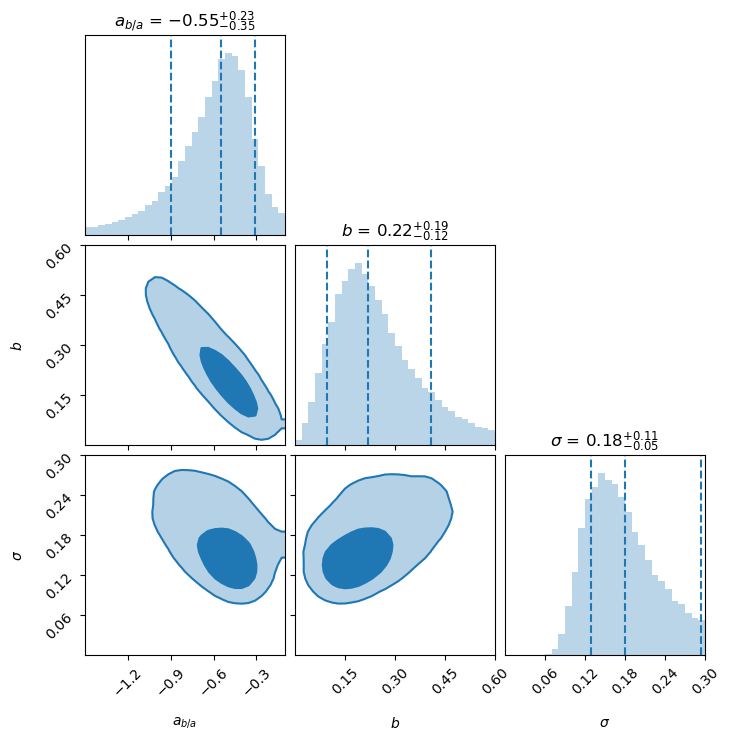

In [124]:
fig = corner.corner(z_mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.5, -0.1], [0, 0.6], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

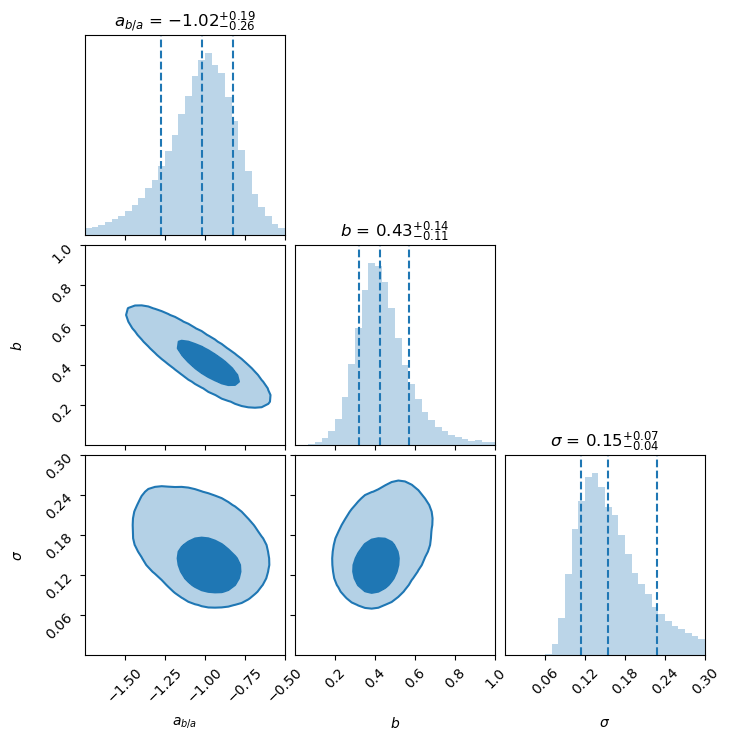

In [121]:
fig = corner.corner(g_mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-1.75, -0.5], [0, 1], [0, 0.3]],
                    # range=[[-6, 6], [-3, 3], [0, 3]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

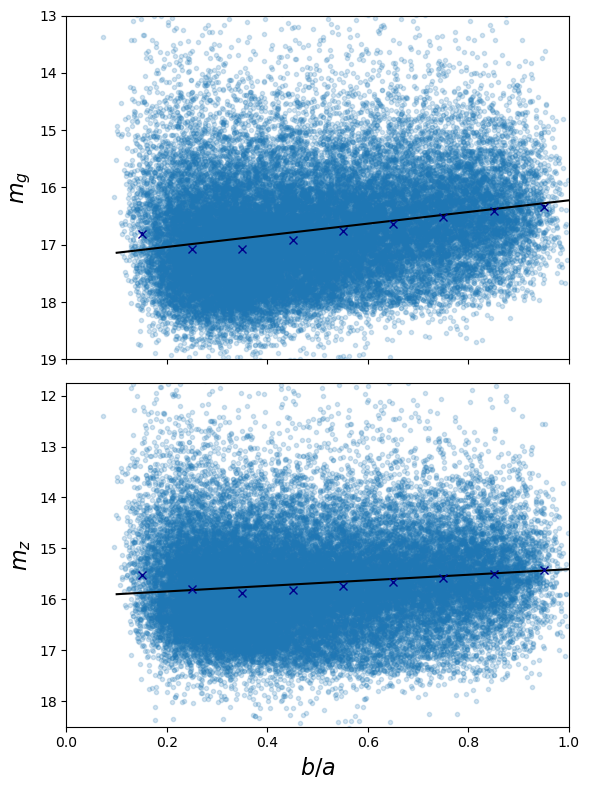

In [122]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True, sharey=False, tight_layout=True)


ax = axes[0]
ax.plot(gals['BA'], gals['G_MAG_SB26_CORR'], '.', alpha=0.2)
ax.errorbar(ba + 0.05, mg_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

ax.plot([0.1, 1], Ag_ba*np.array([0.1, 1]) + (Bg + mg_median), 'k')

ax.set_xlim([0, 1])
ax.set_ylim([19, 13])

# ax.set_tick_params('both', which='major', labelsize=14)

ax.set_ylabel('$m_g$', fontsize=16)


ax = axes[1]
ax.plot(gals['BA'], gals['Z_MAG_SB26_CORR'], '.', alpha=0.2)
ax.errorbar(ba + 0.05, mz_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

ax.plot([0.1, 1], Az_ba*np.array([0.1, 1]) + (Bz + mz_median), 'k')

ax.set_ylim([18.5, 11.75])

# ax.set_tick_params('both', which='major', labelsize=14)

ax.set_xlabel('$b/a$', fontsize=16)
ax.set_ylabel('$m_z$', fontsize=16);


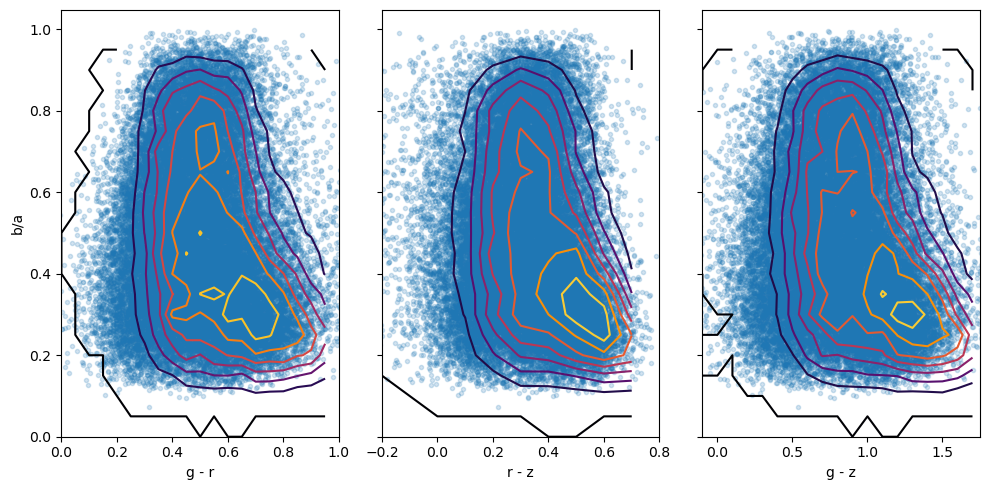

In [127]:
#### See if this correlation got fixed:

internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [Az_ba, Bz], 
                                                         [Az_ba_err, Bz_err])

z_mag_sb26_corr = gals['Z_MAG_SB26_CORR'] - internalDust_corr
z_mag_sb26_corr_err = np.sqrt(gals['Z_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)


internalDust_corr, internalDust_corr_err = internal_dust(gals['BA'], 
                                                         [Ag_ba, Bg], 
                                                         [Ag_ba_err, Bg_err])

g_mag_sb26_corr = gals['G_MAG_SB26_CORR'] - internalDust_corr
g_mag_sb26_corr_err = np.sqrt(gals['G_MAG_SB26_ERR_CORR']**2 + internalDust_corr_err**2)

fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,5))

counts, xbins, ybins = np.histogram2d(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(0,1.05,0.05), np.arange(0,1.05,0.05)])
ax[0].plot(g_mag_sb26_corr - r_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[0].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')
ax[0].set_xlim([0, 1])

counts, xbins, ybins = np.histogram2d(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(-0.2,0.9,0.1), np.arange(0,1.05,0.05)])
ax[1].plot(r_mag_sb26_corr - z_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[1].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[1].set_xlabel('r - z')
ax[1].set_xlim([-0.2, 0.8])

counts, xbins, ybins = np.histogram2d(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], 
                                      gals['BA'], 
                                      bins=[np.arange(-0.1,1.85,0.1), np.arange(0,1.05,0.05)])
ax[2].plot(g_mag_sb26_corr - z_mag_sb26_corr, gals['BA'], '.', alpha=0.2)
ax[2].contour(xbins[:-1], ybins[:-1], counts.T, cmap='inferno')
ax[2].set_xlabel('g - z')
ax[2].set_xlim([-0.1, 1.75]);

In [128]:
temp_outfile = open('jura_internalDust_z0p1_mcmc.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median, g_mcmc_samples, mg_median, z_mcmc_samples, mz_median), temp_outfile)
temp_outfile.close()

In [129]:
gals.write('SGA-2020_jura_Vrot_VI.fits', overwrite=True)